In [16]:
import numpy as onp
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from functools import partial
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)


jax backend gpu


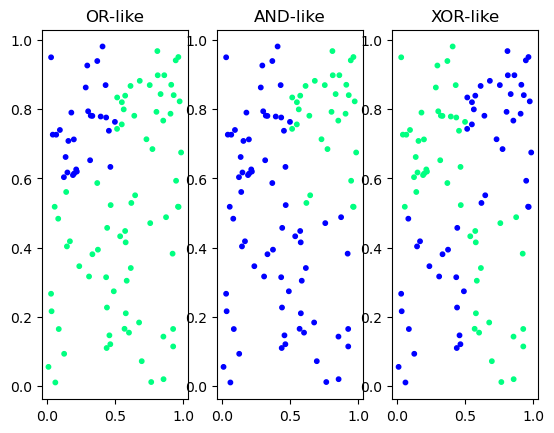

In [17]:
# we can generate a OR-like , AND-like and XOR-like dataset with float values
x = jax.random.uniform(key, shape=(100,2), minval=0, maxval=1)

t_or = (x[:,0] >= 0.5) | (x[:,1] < 0.6)
t_and = (x[:,0] >= 0.5) & (x[:,1] > 0.5)
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)


fig, ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0],x[:,1], s=10, c=t_or, cmap='winter')
ax[0].set_title("OR-like")
ax[1].scatter(x[:,0],x[:,1], s=10, c=t_and, cmap='winter')
ax[1].set_title("AND-like")
ax[2].scatter(x[:,0],x[:,1], s=10, c=t_xor, cmap='winter')
ax[2].set_title("XOR-like")
plt.show()


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, t_or, test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
t_train = np.asarray(y_train).reshape(-1, 1)
t_test = np.asarray(y_test).reshape(-1, 1)

print(X_train.shape, t_train.shape, X_test.shape, t_test.shape)

(80, 2) (80, 1) (20, 2) (20, 1)


In [26]:
import ADAMLL as ada






def loss(w0,w1, b0, b1, X, T):
    """
    Loss function
    """
    a0 = ada.activations.sigmoid(X @ w0 + b0)
    a1 = ada.activations.sigmoid(a0 @ w1 + b1)
    return ada.CA(a1, T)














def predict(params, X):
    return np.dot(X, params[0]['w']) + params[0]['b']


# Super class for all linear regression models
class NN():

    def __init__(self , eta=0.1, epochs=100, tol=0.001, optimizer='sgd', alpha=0, gamma=0, epsilon=0.0001, decay=0.9, beta1=0.9, beta2=0.999):
        self.eta = eta
        self.epochs = epochs
        self.tol = tol
        self.optimizer = optimizer
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2



    def init_optimizer(self, params):
        match self.optimizer:
            case 'sgd':
                optimizer = create_update_sgd(self.eta, self.gamma)
                optimizerState = init_SGD_state(params)
                return optimizer, optimizerState
            case 'rgd':
                optimizer = create_update_ridge(self.eta, self.gamma, self.alpha)
                optimizerState = init_ridge_state(params)
                return optimizer, optimizerState
            case 'adagrad':
                optimizer = create_update_adagrad(self.eta, self.epsilon, self.gamma)
                optimizerState = init_adagrad_state(params)
                return optimizer, optimizerState
            case 'rmsprop':
                optimizer = create_update_rmsprop(self.eta, self.epsilon, self.decay)
                optimizerState = init_rmsprop_state(params)
                return optimizer, optimizerState
            case 'adam':
                optimizer = create_update_adam(self.eta, self.beta1, self.beta2, self.epsilon)
                optimizerState = init_adam_state(params)
                return optimizer, optimizerState
            case _:
                raise ValueError(f"Unknown optimizer {self.optimizer}")



    def fit(self, X, t, X_val, t_val, batch_size=None ):
        (N, m) = X_train.shape
        if batch_size is None:
            batch_size = N
        key = jax.random.PRNGKey(1234)
        params = init_network_params([m, 1], key)
        update_params, opt_state = self.init_optimizer(params) 
        batches = int(N/batch_size)
        loss = np.zeros(self.epochs)

        @jax.jit
        def step(params, opt_state, X, t):
            grads = gradients(X, t, params)
            params, opt_state = update_params(params, grads, opt_state)
            return params, opt_state

        for e in range(self.epochs):
            for _ in range(batches):

                key, subkey = jax.random.split(key)
                random_index = batch_size * jax.random.randint(subkey, minval=0, maxval=batches, shape=())
                X_batch = X[random_index:random_index+batch_size]
                t_batch = t[random_index:random_index+batch_size]

                params, opt_state = step(params, opt_state, X_batch, t_batch)

                current_loss = MSE(self.predict(X_val, params), t_val)

                # clip gradients
                if not np.isfinite(current_loss).all():
                    params = jax.tree_map(lambda p: np.clip(p, -100, 100), params)

                loss = loss.at[e].set(current_loss)

                # Early stopping condition
                if e > 10 and np.abs(loss[e-10] - loss[e]) < self.tol:
                    loss = loss.at[e+1:].set(loss[e]) 
                    break


        print_message(f"Training stopped after {e} epochs")
        return loss , params

    
    
    def predict(self, X):
        forw = self.forward(X)
        return np.argmax(forw[1], axis=1)




    def predict(self, X, params):
        return np.dot(X, params[0]['w']) + params[0]['b']



In [20]:
nn = NN()

for gate in gateList:
    nn.fit(X, gate)
    
    prediction = nn.predict(X)
    
    print(prediction)

NameError: name 'gateList' is not defined